In [30]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pywt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings

In [31]:
# settings
plt.rcParams['figure.figsize'] = (10,4)
sns.set()
warnings.filterwarnings('ignore')

In [32]:
from libary.Database import Database

database = Database(schema='pesquisa', table='mview_dados_tratados', ambiente = 1, path='../.env')
data = database.select_table(query="""
with periodo as
(select dc.data_padrao::date periodo_mensal
from publico.dim_calendario dc
where dc.data_padrao >= '2017-01-01'::date and 
dc.data_padrao < '2021-12-31'::date
group by dc.data_padrao
order by 1),

amostras as
(select date_trunc('week', vls.periodo) as periodo_trunc, sensor, avg(valor) as valor
from pesquisa.view_leituras_sensores vls
where vls.id_direcao_saida = 2 and 
vls.periodo >= '2017-01-01'::date and 
vls.periodo < '2021-12-31'::date and
vls.id_area = 2
and sensor != 'PZ-BM-BV-52'
group by date_trunc('week', vls.periodo), sensor),

query as
(select date_trunc('week', p.periodo_mensal)::date as periodo,
vls.sensor,
avg(vls.valor)::numeric(12,2) as valor,
max(dct."Value") as chuva
from periodo p
left join amostras vls on p.periodo_mensal = vls.periodo_trunc
left join pesquisa.dados_chuva_tratados dct on vls.periodo_trunc = dct.data_padrao
group by date_trunc('week', p.periodo_mensal), vls.sensor)

select * from query where sensor is not null""", geom=False)

In [33]:
data.head()

,periodo,sensor,valor,chuva
0,2017-01-02,PE-BM-BV-51,89.20,45.9
1,2017-01-02,PE-BM-BV-52,76.62,45.9
2,2017-01-02,PE-BM-BV-71,82.52,45.9
3,2017-01-02,PE-BM-BV-72,77.28,45.9
4,2017-01-02,PE-BM-BV-81,89.10,45.9


In [34]:
dfn = data.pivot(index=['periodo'], columns='sensor', values=['valor'])
dfn = dfn['valor']

In [35]:
dfx = dfn.fillna(method='ffill').fillna(method='bfill')
dfx.columns = dfx.columns.str.lower()
dfx.head()

sensor,pe-bm-bv-51,pe-bm-bv-52,pe-bm-bv-71,pe-bm-bv-72,pe-bm-bv-81,pe-bm-bv-82,pz-bm-bv-11,pz-bm-bv-12,pz-bm-bv-13,pz-bm-bv-14,...,pz-bm-bv-53,pz-bm-bv-54,pz-bm-bv-55,pz-bm-bv-56,pz-bm-bv-71,pz-bm-bv-72,pz-bm-bv-73,pz-bm-bv-81,pz-bm-bv-82,pz-bm-bv-83
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,89.20,76.62,82.52,77.28,89.10,84.87,75.06,82.60,70.67,74.57,...,34.88,35.64,34.98,34.69,65.82,65.21,56.66,78.20,78.54,77.90
2017-01-09,89.35,76.78,82.59,77.36,89.17,84.92,75.00,82.61,70.68,74.56,...,34.82,35.58,34.97,34.87,65.84,65.21,56.66,78.22,78.54,77.88
2017-01-16,89.37,76.88,82.64,77.42,89.18,84.95,75.01,82.63,70.67,74.59,...,34.83,35.58,34.99,34.91,65.79,65.21,56.66,78.20,78.54,77.89
2017-01-23,89.36,76.99,82.69,77.49,89.19,84.94,75.18,82.65,70.66,74.57,...,34.83,35.61,35.02,34.94,65.77,65.21,56.66,78.17,78.54,77.92
2017-01-30,89.34,77.08,82.72,77.53,89.19,84.96,75.02,82.68,70.66,74.59,...,34.89,35.66,35.07,35.02,65.84,65.21,56.66,78.19,78.54,77.95


In [36]:
import plotly.express as px
fig = px.line(data, x='periodo', y='valor', color='sensor')
fig.show()

pe-bm-bv-51 Index([2021-12-20], dtype='object', name='periodo')


<AxesSubplot: xlabel='periodo'>

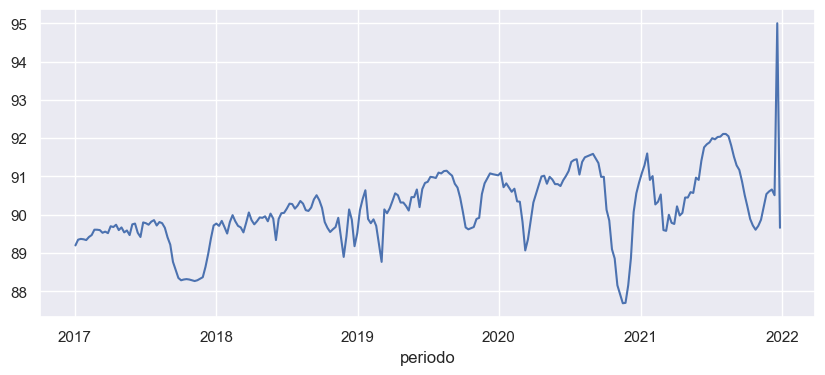

In [37]:
col_num = 0
pos_num = 250
nome = dfx.columns[col_num]
valor = 95

dfx.loc[pos_num:pos_num+1, nome] = valor

index = dfx[dfx[nome] == valor].index

print(nome, index)
dfx[nome].plot()

In [38]:
dfx.shape

(252, 28)

In [39]:
close_data = dfx.values

split_percent = 0.8
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

scaler1 = MinMaxScaler(feature_range=(-1, 1))
close_train = scaler1.fit_transform(close_train)

scaler2 = MinMaxScaler(feature_range=(-1, 1))
close_test = scaler2.fit_transform(close_test)

date_train = dfx.index[:split]
date_test = dfx.index[split:]

inicio_teste = date_test[0].strftime('%Y-%m-%d')
inicio_teste

'2021-01-11'

In [40]:
from libary.Database import Database

database = Database(schema='pesquisa', table='mview_dados_tratados', ambiente = 1, path='../.env')
anomalias = database.select_table(query=f"""
select date_trunc('week', vls.periodo)::date as periodo,
count(vls.id_estado) as qtd_estado
from pesquisa.view_leituras_sensores vls
where vls.id_estado = 1 and vls.periodo::date > '{inicio_teste}'::date 
and sensor != 'PZ-BM-BV-52'
group by date_trunc('week', periodo)""", geom=False)

anomalias = anomalias.set_index('periodo')
anomalias = anomalias['qtd_estado'].append(pd.Series(valor, index=index))
anomalias

periodo
2021-12-20    95
dtype: int64

In [41]:
row, col = dfx.shape

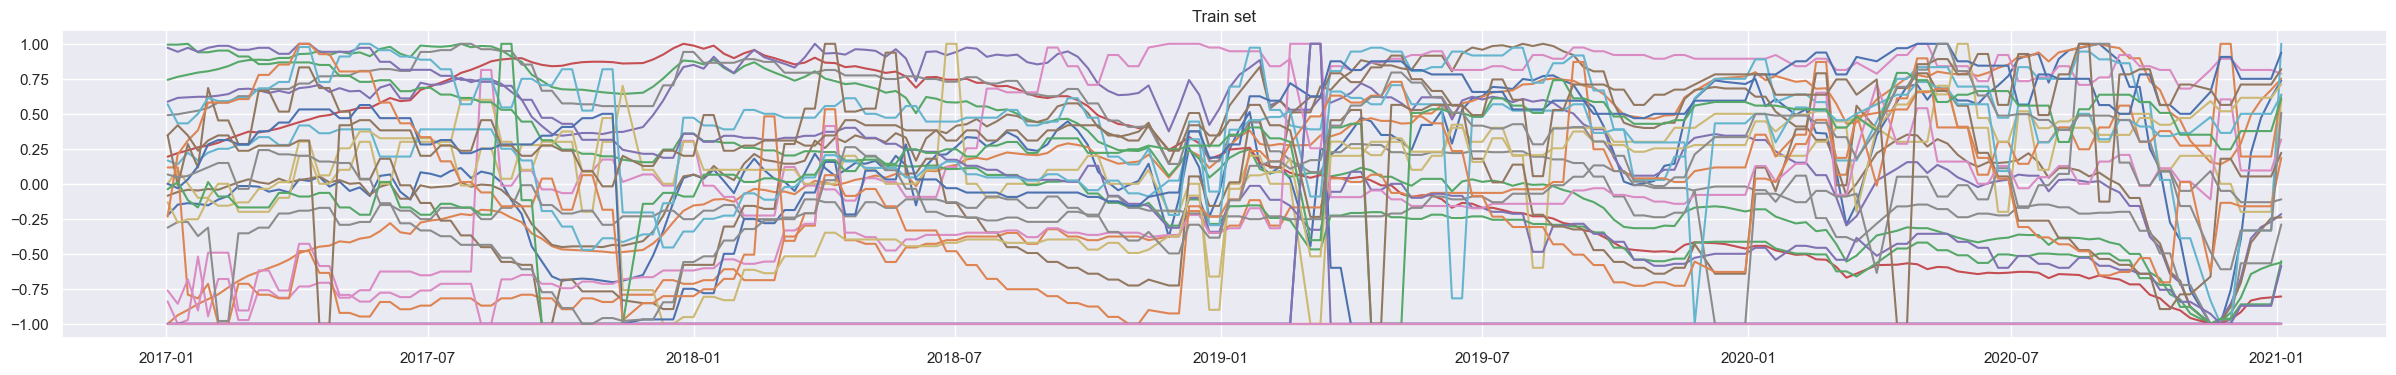

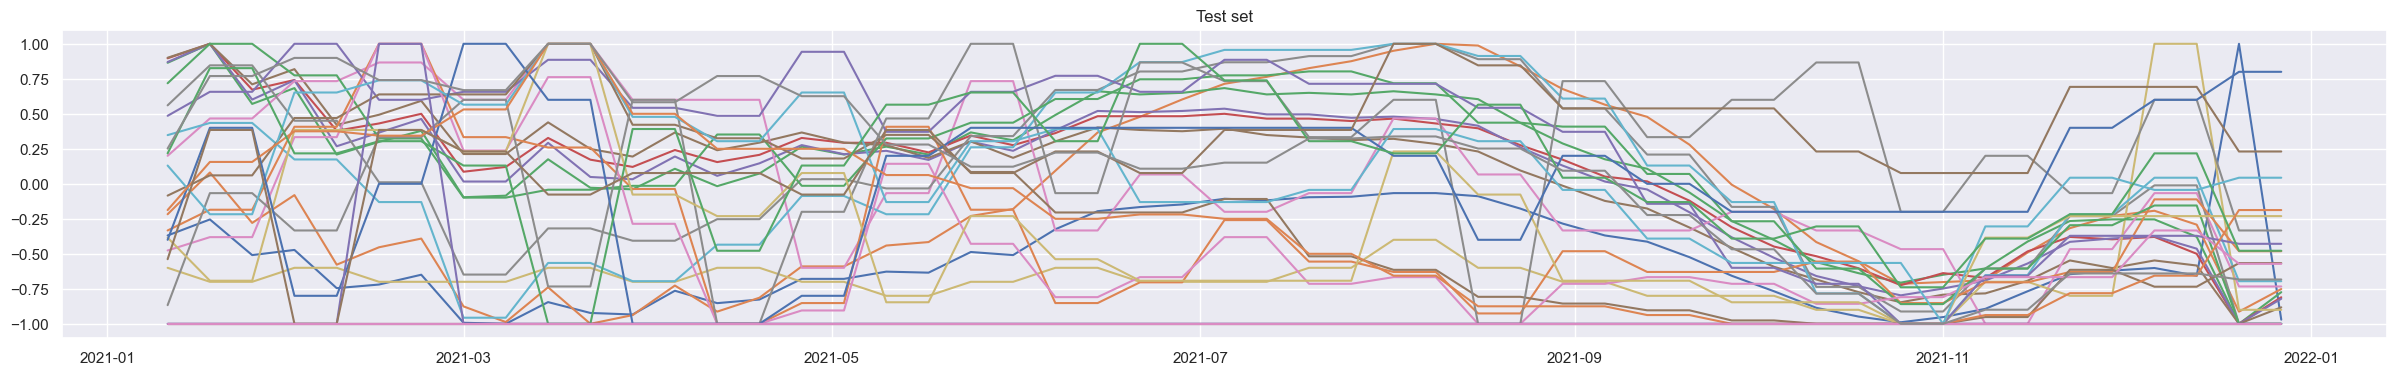

In [42]:
#plots
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(date_train, close_train)
plt.show()

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(date_test, close_test)
plt.show()

In [43]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

look_back = 1
n_features = col

# Criar X_train e y_train
X_train = np.array([close_train[i:i+look_back] for i in range(len(close_train)-look_back)])
y_train = np.array([close_train[i+look_back] for i in range(len(close_train)-look_back)])

X_test = np.array([close_test[i:i+look_back] for i in range(len(close_test)-look_back)])
y_test = np.array([close_test[i+look_back] for i in range(len(close_test)-look_back)])

# Reshape para o formato [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, close_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, close_test.shape[1]))

# Criando o modelo
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, n_features), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(Dense(n_features))

# Compilando o modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinando o modelo
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
200/200 - 4s - loss: 0.1779 - 4s/epoch - 18ms/step
Epoch 2/100
200/200 - 1s - loss: 0.0674 - 589ms/epoch - 3ms/step
Epoch 3/100
200/200 - 1s - loss: 0.0520 - 634ms/epoch - 3ms/step
Epoch 4/100
200/200 - 1s - loss: 0.0473 - 618ms/epoch - 3ms/step
Epoch 5/100
200/200 - 1s - loss: 0.0416 - 638ms/epoch - 3ms/step
Epoch 6/100
200/200 - 1s - loss: 0.0395 - 566ms/epoch - 3ms/step
Epoch 7/100
200/200 - 0s - loss: 0.0369 - 448ms/epoch - 2ms/step
Epoch 8/100
200/200 - 0s - loss: 0.0361 - 451ms/epoch - 2ms/step
Epoch 9/100
200/200 - 1s - loss: 0.0347 - 528ms/epoch - 3ms/step
Epoch 10/100
200/200 - 1s - loss: 0.0347 - 581ms/epoch - 3ms/step
Epoch 11/100
200/200 - 1s - loss: 0.0338 - 810ms/epoch - 4ms/step
Epoch 12/100
200/200 - 1s - loss: 0.0336 - 601ms/epoch - 3ms/step
Epoch 13/100
200/200 - 1s - loss: 0.0325 - 580ms/epoch - 3ms/step
Epoch 14/100
200/200 - 1s - loss: 0.0308 - 679ms/epoch - 3ms/step
Epoch 15/100
200/200 - 1s - loss: 0.0308 - 831ms/epoch - 4ms/step
Epoch 16/100
200/200 

In [44]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred[:, -1, :])

print("Erro Quadrático Médio (MSE) no conjunto de teste:", mse)

2/2 [==============================] - 1s 3ms/step
Erro Quadrático Médio (MSE) no conjunto de teste: 0.23542560532594553


In [45]:
y_pred2 = scaler2.inverse_transform(y_pred[:, -1, :])

In [46]:
from tensorflow.keras.models import load_model
model.save('model2.h5')
model = load_model('model2.h5')

In [47]:
pred_x_train = model.predict(X_train)
pred_x_test = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [74]:
col_num

range(0, 0)

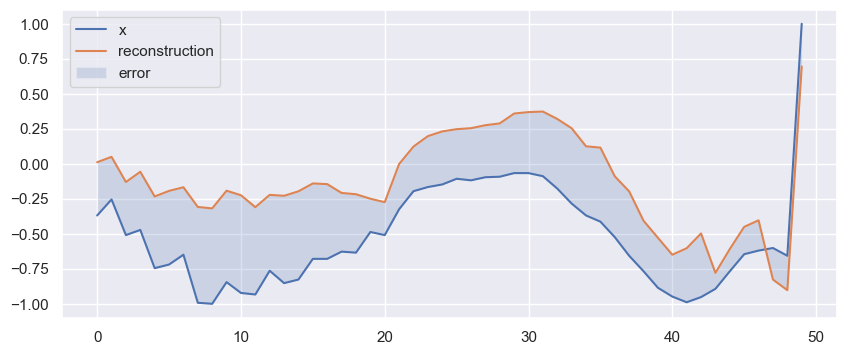

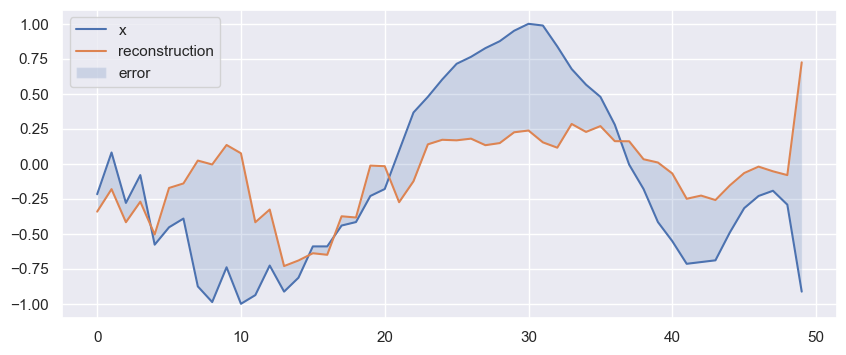

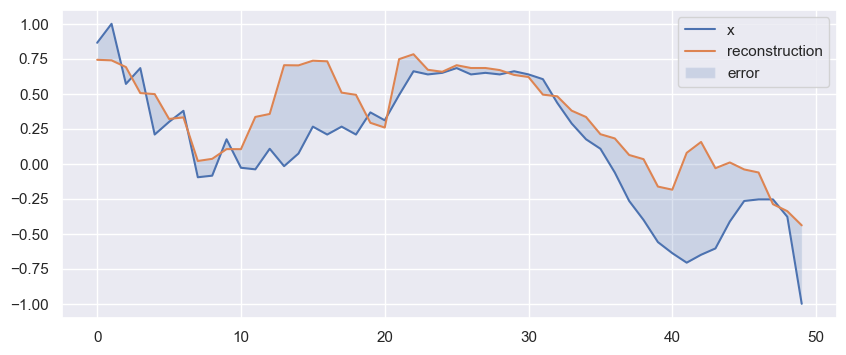

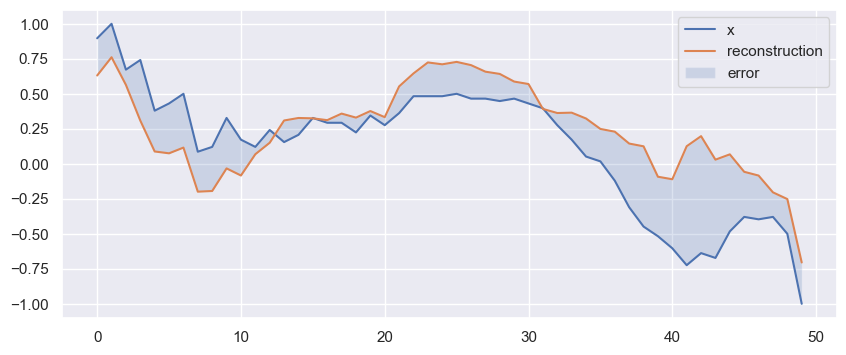

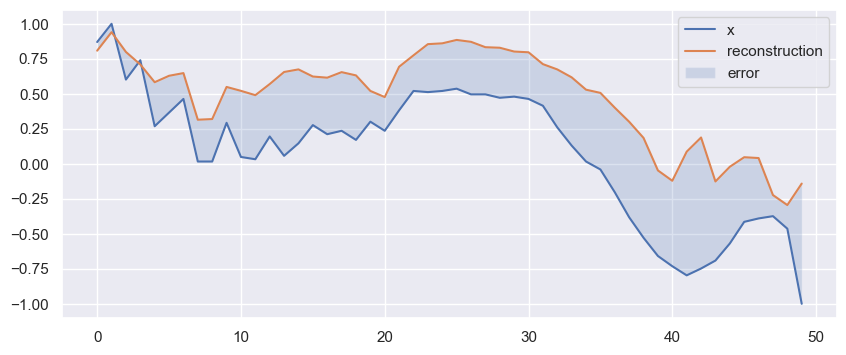

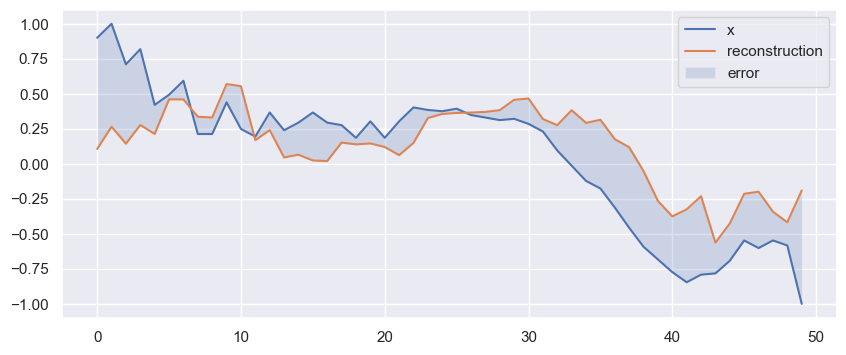

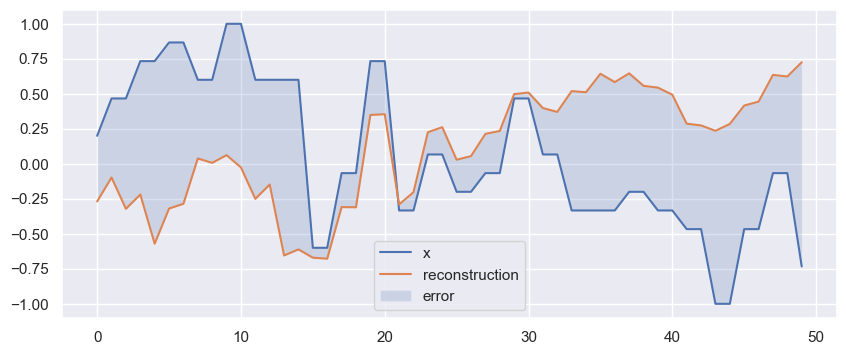

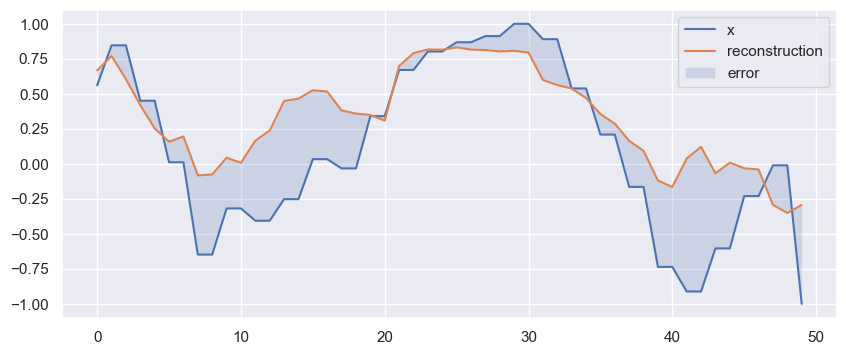

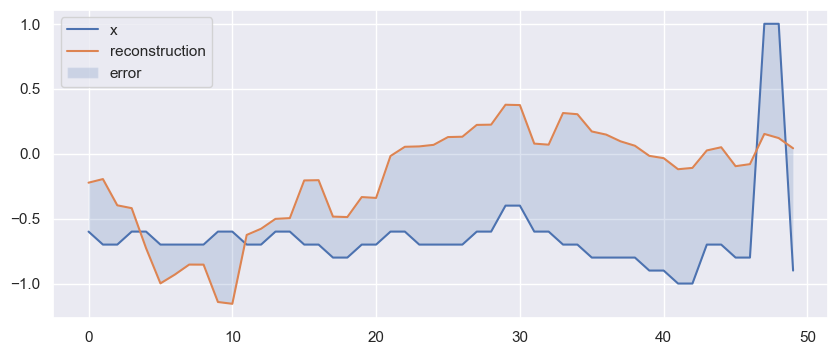

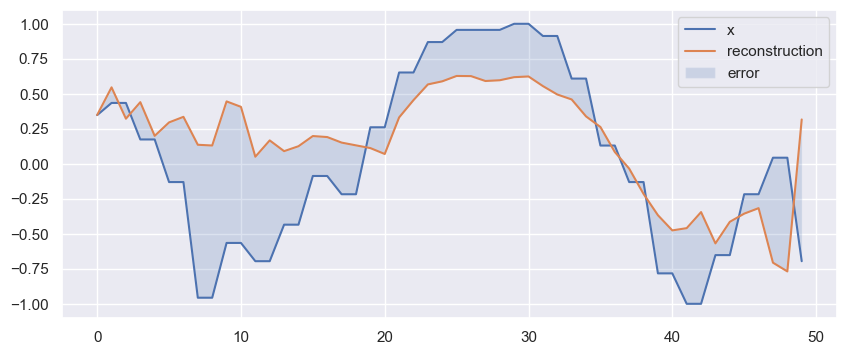

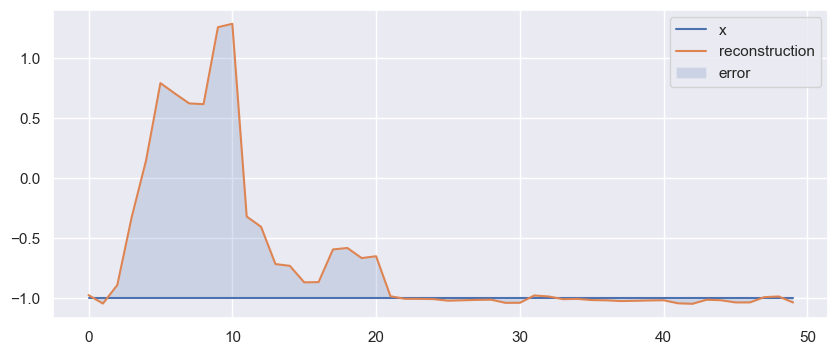

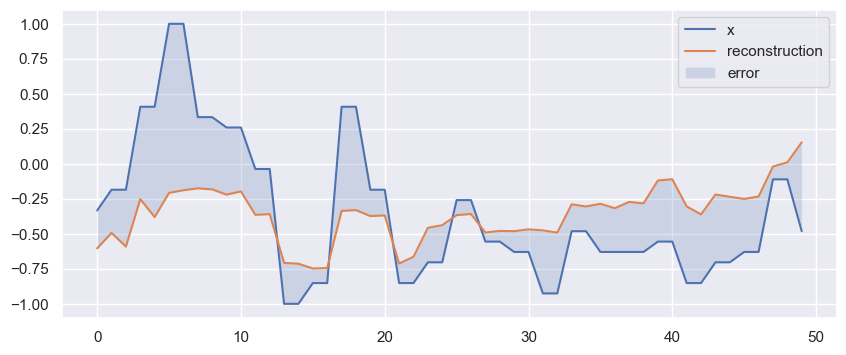

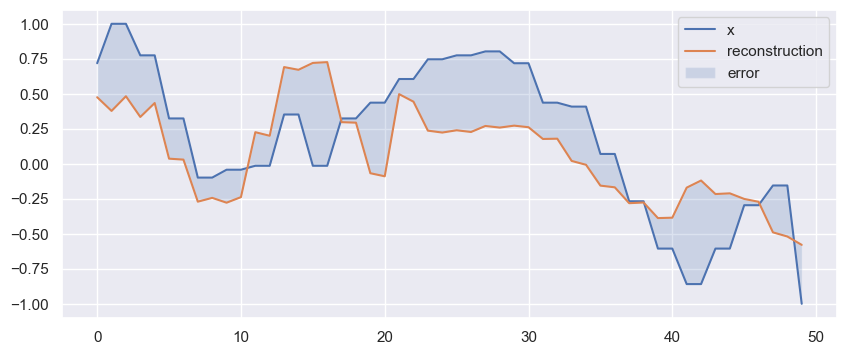

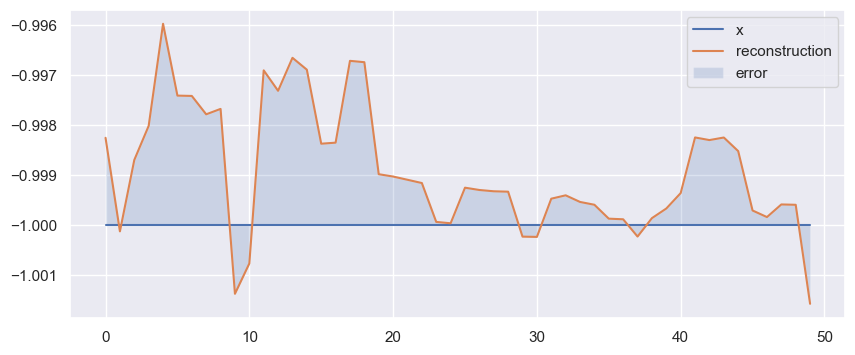

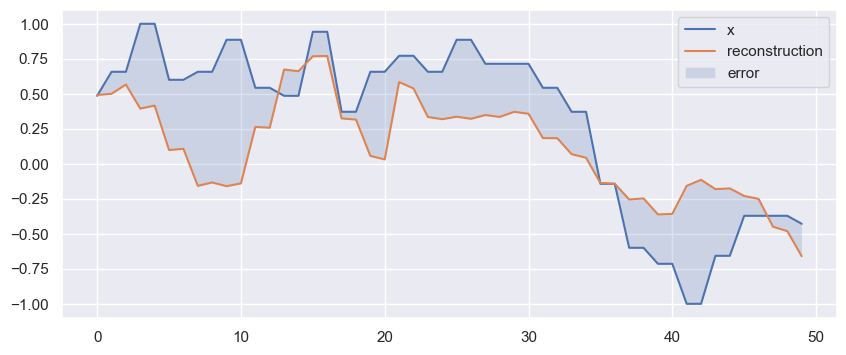

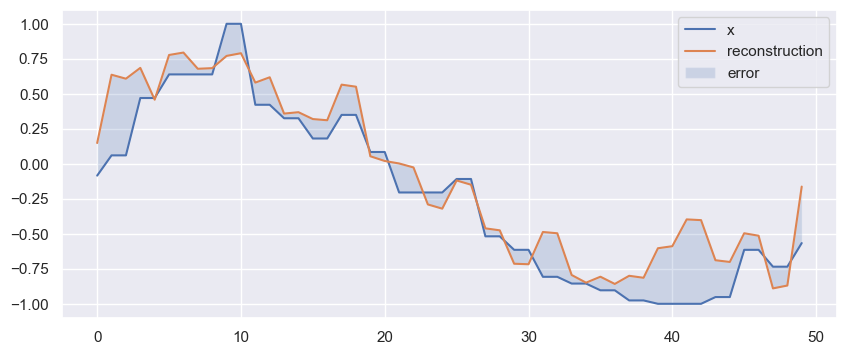

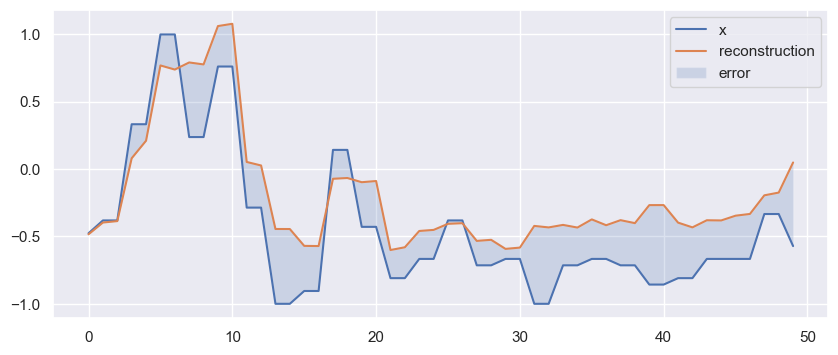

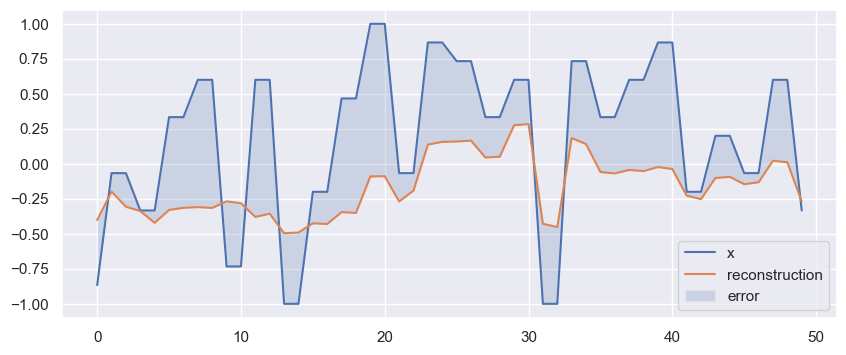

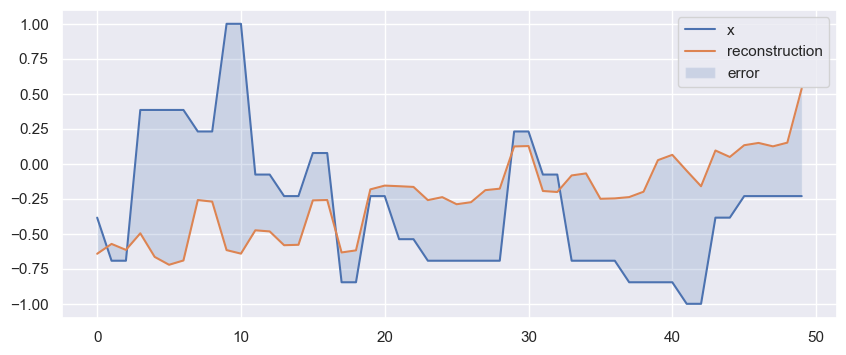

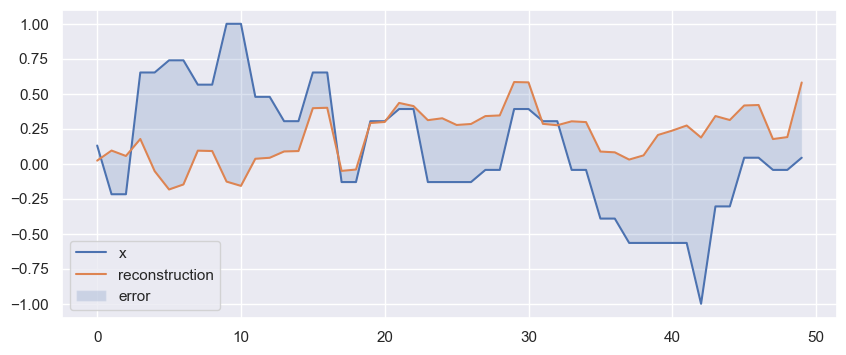

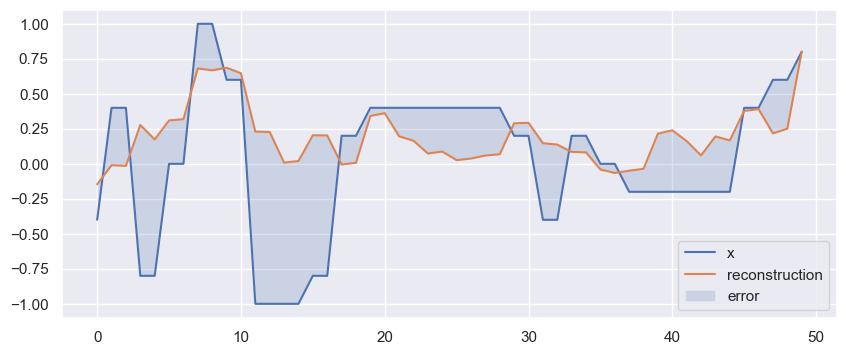

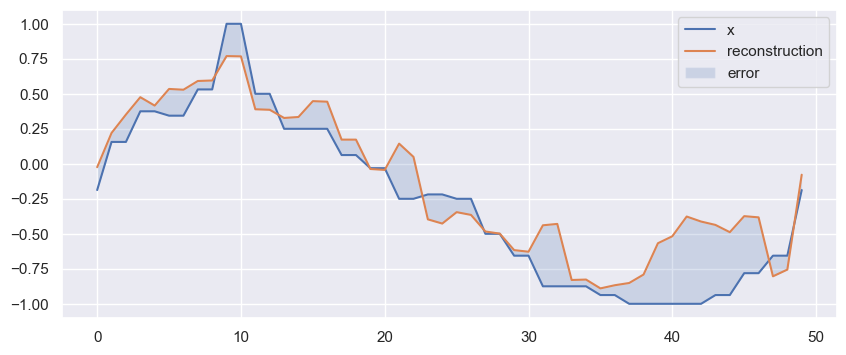

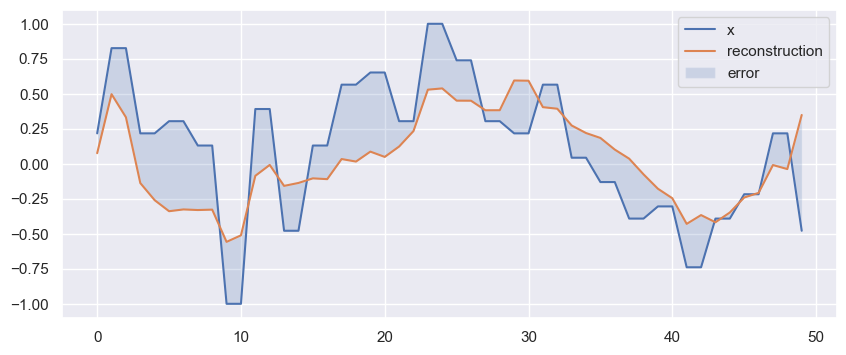

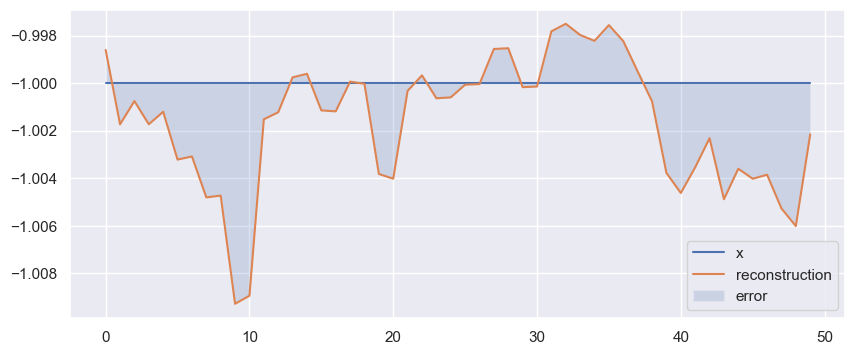

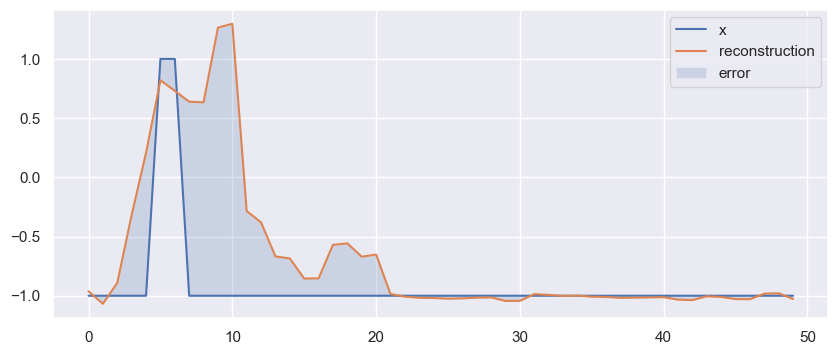

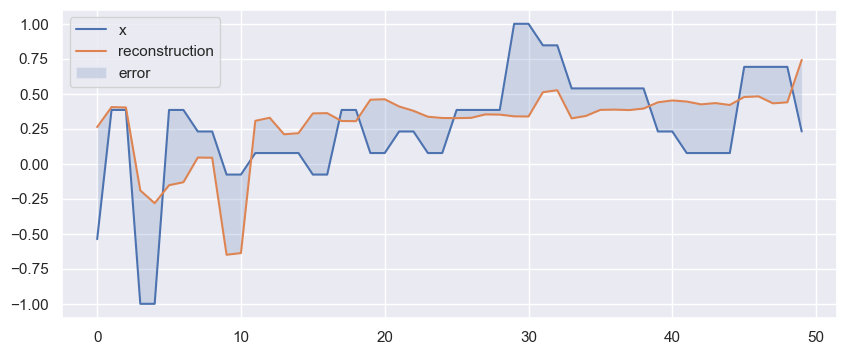

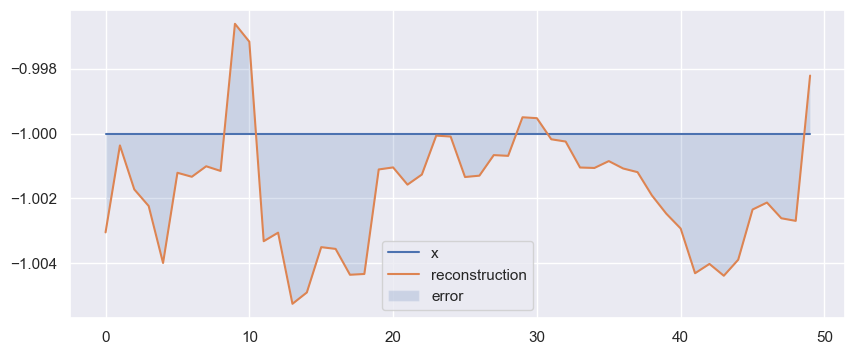

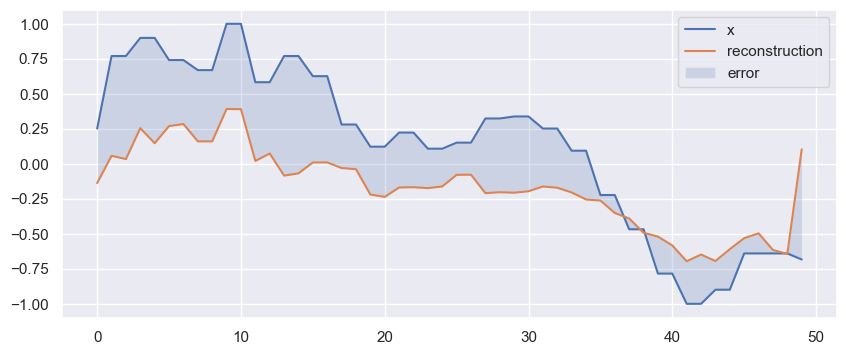

In [77]:
from IPython.display import display, clear_output

%matplotlib inline
for i in range(col):
    fig, ax = plt.subplots()
    x = X_test[:, -1, i].flatten()
    x_pred = pred_x_test[:, -1, i].flatten()
    ax.plot(x, label='x')
    ax.plot(x_pred, label='reconstruction')
    ax.fill_between(np.arange(len(x)), x, x_pred, alpha=0.2, label='error')
    ax.legend()
    plt.show()

In [49]:
mse = lambda x, x_pred: np.mean(np.abs(x - x_pred)**2, axis=1)

train_mae_loss = pd.DataFrame(mse(close_train[:-look_back], pred_x_train[:, -1, :]), columns=['Error'])
test_mae_loss = pd.DataFrame(mse(close_test[:-look_back], pred_x_test[:, -1, :]), columns=['Error'])

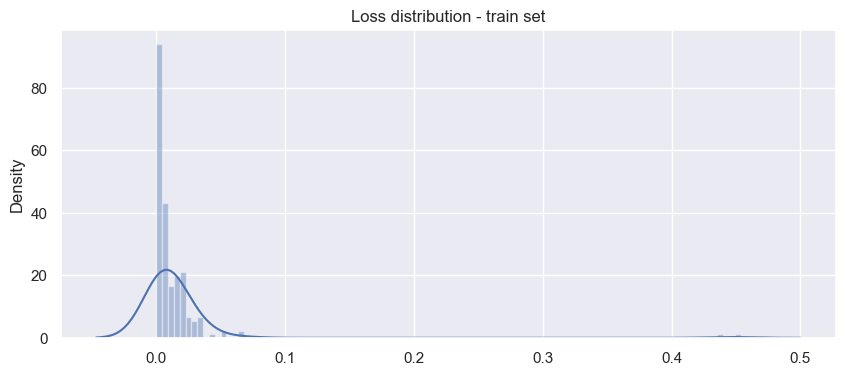

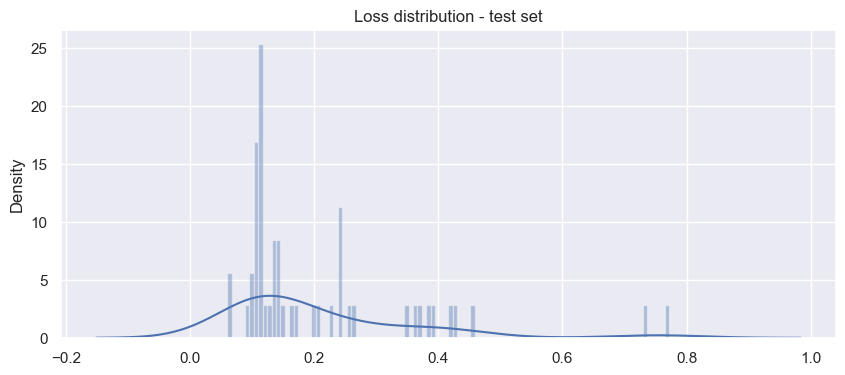

In [50]:
plt.title('Loss distribution - train set')
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

plt.title('Loss distribution - test set')
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

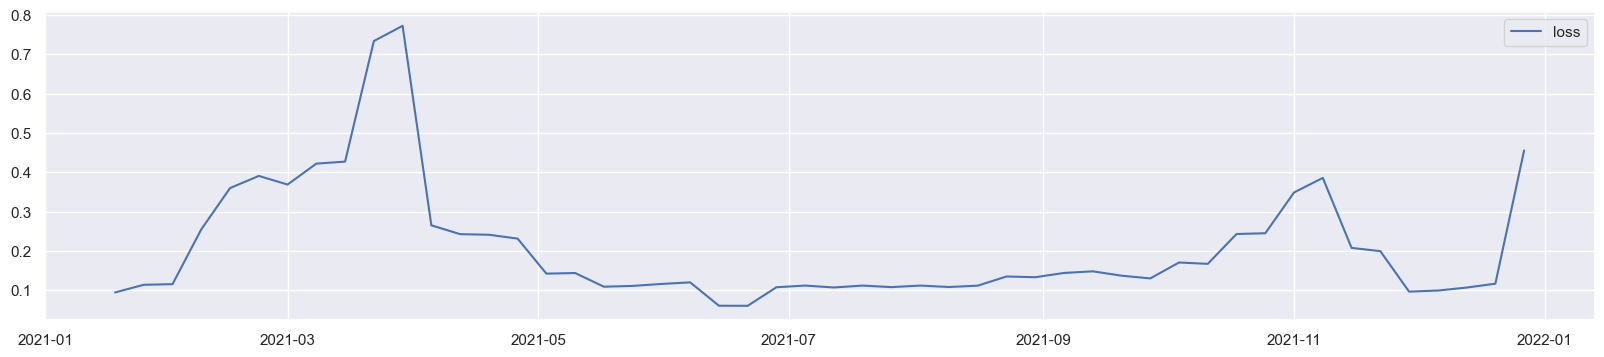

In [51]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(date_test[look_back:], test_mae_loss_array, label='loss')
plt.legend()
plt.show()

In [52]:
print(np.mean(test_mae_loss)[0] + 2 * np.std(test_mae_loss)[0])

0.5140232949919503


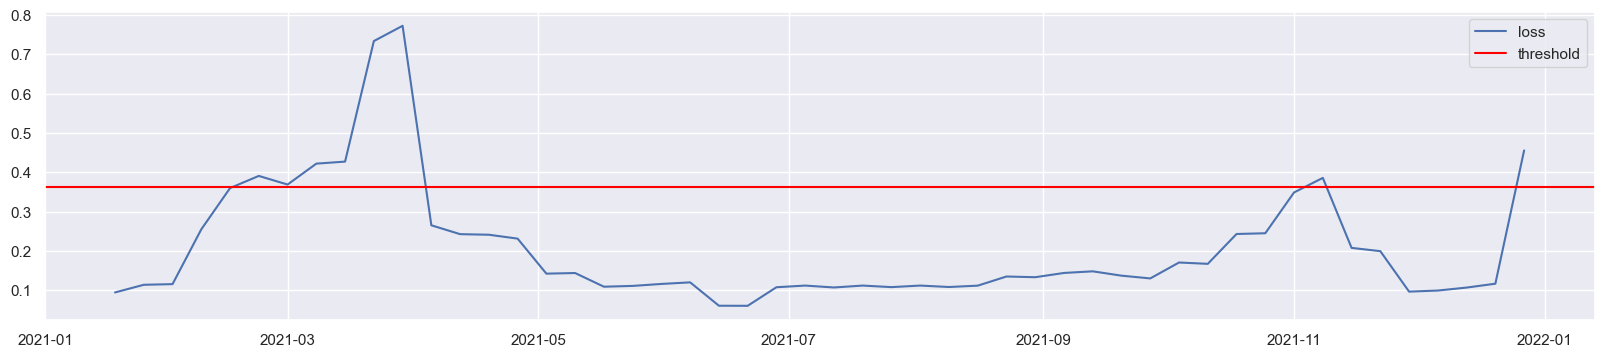

In [53]:
threshold = np.mean(test_mae_loss)[0] + 1 * np.std(test_mae_loss)[0]

test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(date_test[look_back:], test_mae_loss_array, label='loss')
plt.axhline(threshold, color='red', label='threshold')
plt.legend()
plt.show()

In [54]:
y_pred = test_mae_loss_array >= threshold
y_pred.shape

(50,)

In [55]:
dates_with_hours_anomalies = close_test[look_back:][y_pred]

print('Dates where anomalies have been detected:')
for d in dates_with_hours_anomalies:
    #print(d)
    pass

Dates where anomalies have been detected:


In [56]:
periodo = date_test[0] >= anomalias.index
dfx[dfx[nome] == valor][nome]

periodo
2021-12-20    95.0
Name: pe-bm-bv-51, dtype: float64

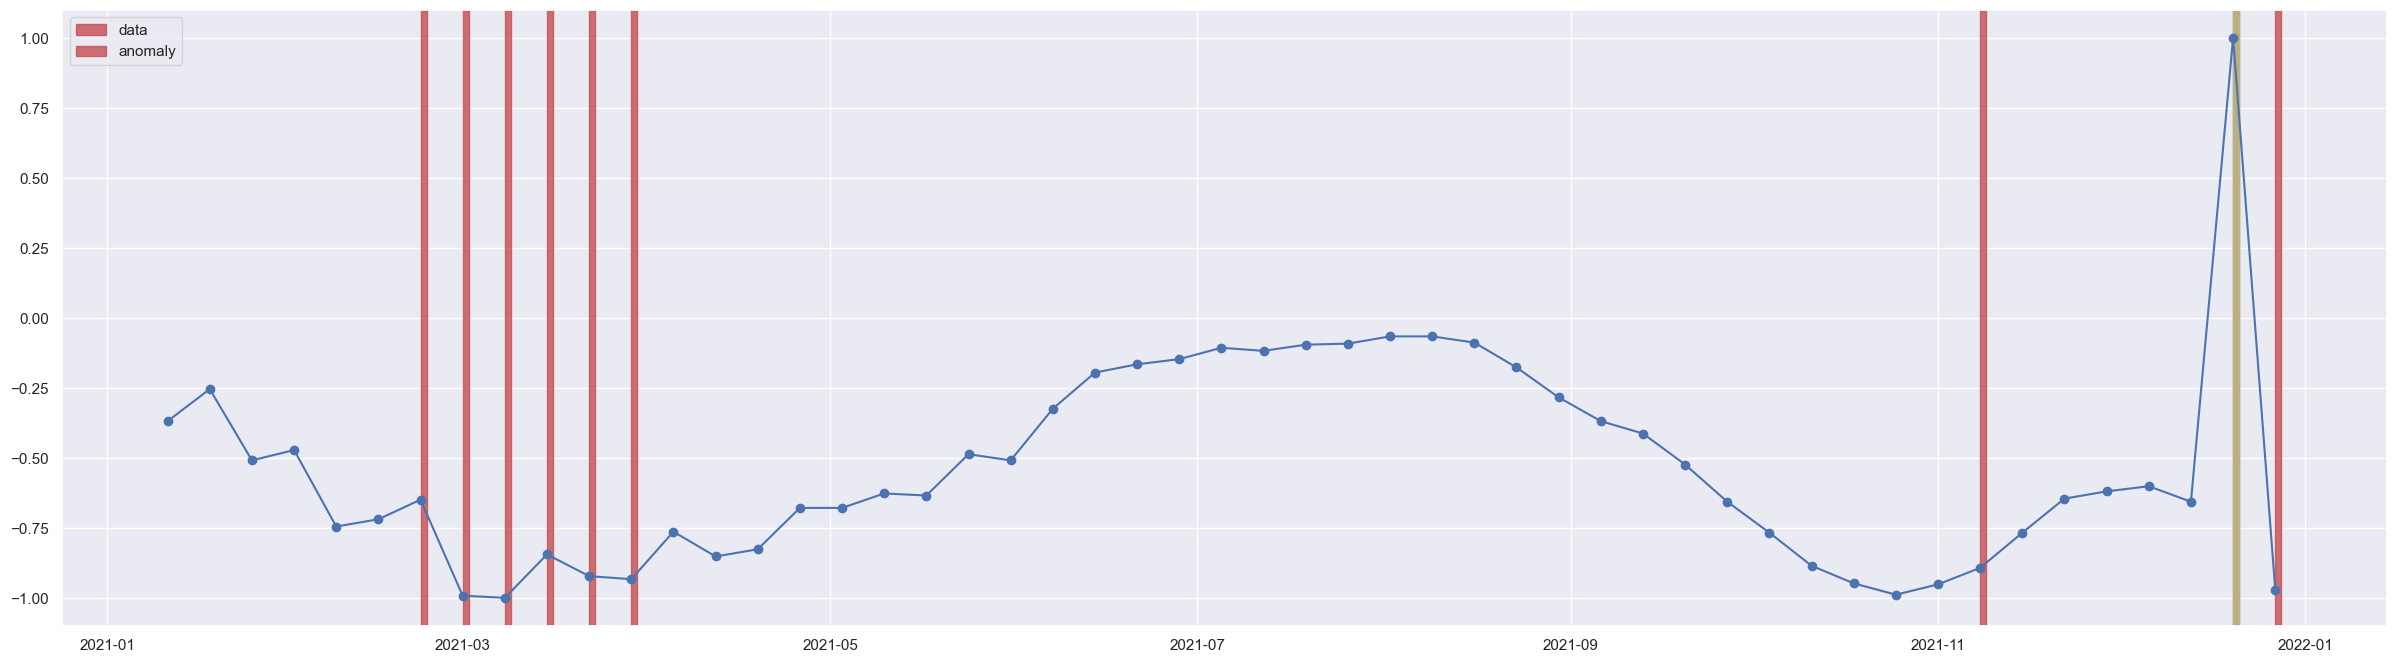

In [57]:
plt.figure(figsize=(30,8))

#Vermelho com predições.
for i in date_test[look_back:][y_pred]:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='r',alpha=0.8)

#Azul com anomalias.
for i in anomalias.index:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='b',alpha=0.8)

#Verde com as anomalias sinteticas.
for i in index:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='y',alpha=0.8)

plt.plot(date_test, close_test[:, col_num], label='data')
plt.scatter(date_test, close_test[:, col_num], label='data')
plt.legend(['data', 'anomaly'])
plt.show()

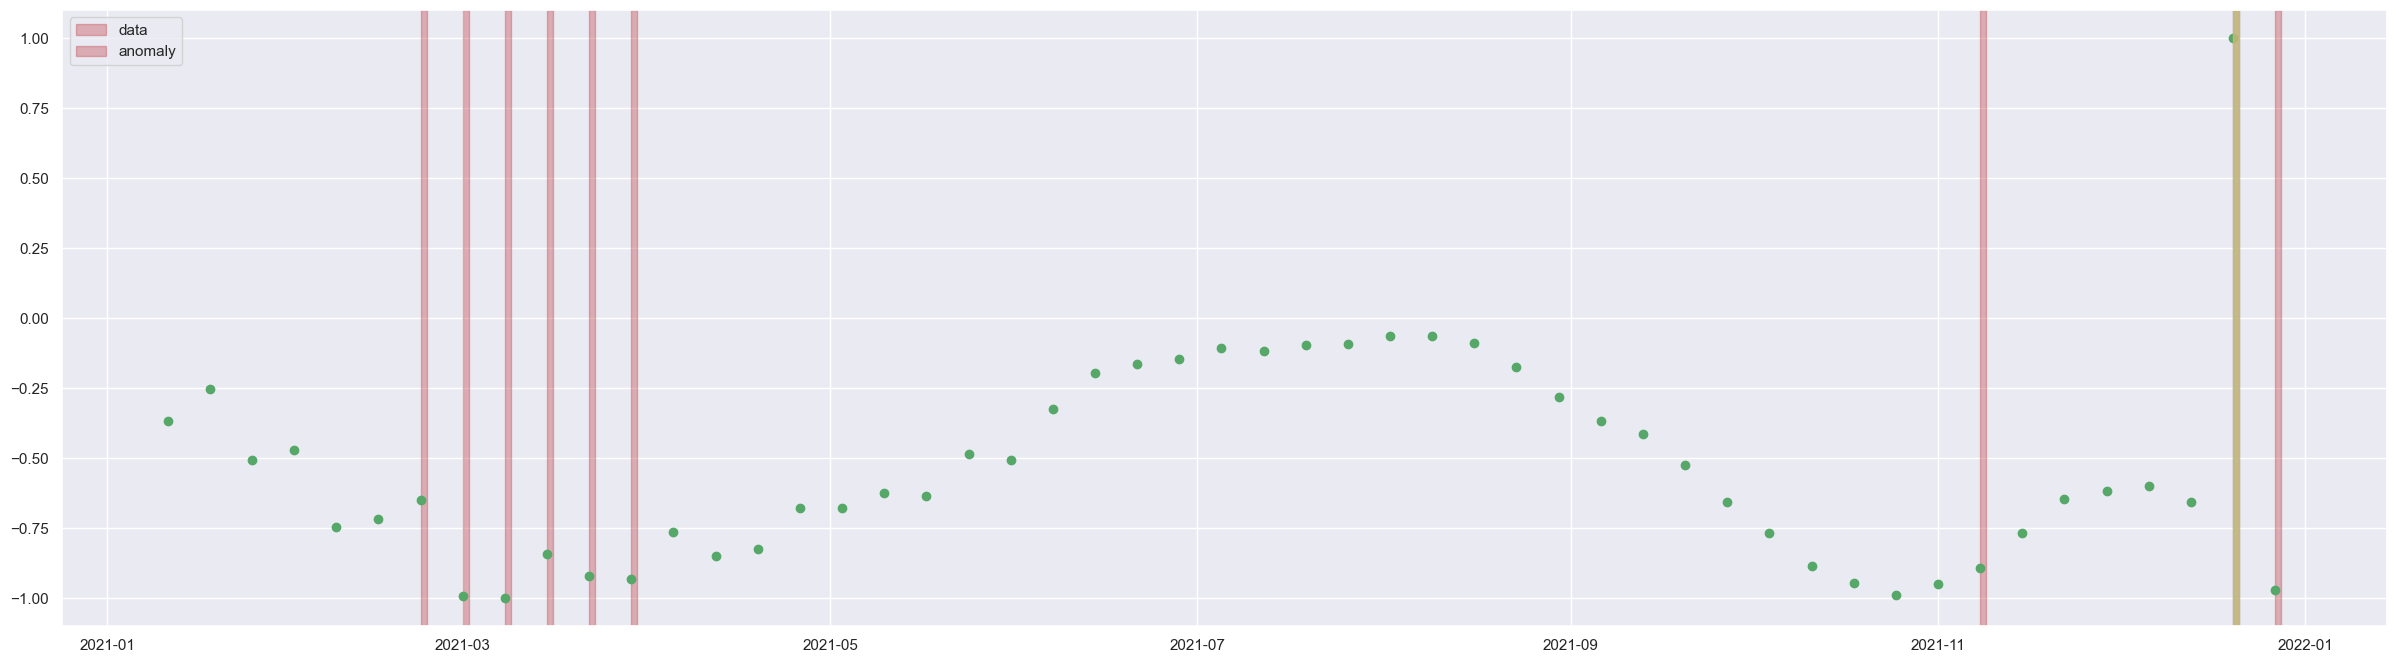

In [58]:
plt.figure(figsize=(30,8))

for i in date_test[look_back:][y_pred]:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='r',alpha=0.4)
#plt.scatter(df.index, df[['pz-bm-bv-53']].rename(columns={'pz-bm-bv-53': 'valor'}))

for i in anomalias.index:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='b',alpha=0.4)

plt.scatter(date_test, close_test[:, col_num], color='g')

for i in index:
    plt.axvspan(i, i + pd.to_timedelta(look_back, unit='D') , color='y',alpha=0.8)
plt.legend(['data', 'anomaly'])
plt.show()